In [99]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import trange

from src.agent import DeterministicAgent
from src.env import BinaryAttributeEnvironment
from src.governance import PassiveGovernance, EUMASGovernance

In [94]:
def run_simulation(agents, environment, governance, number_of_steps):
    environment.reset()
    governance.reset()
    for agent in agents:
        agent.reset()

    result = []
    for step in range(number_of_steps):
        fundamental_actions = [agent.actions for agent in agents]
        allowed_actions = governance.restrict_actions(environment.state, fundamental_actions)
        chosen_actions = [agent.act(environment.state, actions) for agent, actions in zip(agents, allowed_actions)]

        old_state = environment.state
        environment.move(chosen_actions)
        new_state = environment.state

        governance.learn(old_state, chosen_actions, new_state)

        old_cost = governance.cost(old_state)
        new_cost = governance.cost(new_state)

        result.append([step, old_state, old_cost, fundamental_actions, allowed_actions, chosen_actions, new_state, new_cost])

    return pd.DataFrame(result, columns=['step', 'old_state', 'old_cost', 'fundamental_actions', 'allowed_actions', 'chosen_actions', 'new_state', 'new_cost'])

In [95]:
def run_scenario(number_of_simulations, number_of_agents, number_of_variables, number_of_steps, seed=42):
    # Initialize random number generator
    rng = np.random.default_rng(seed)

    cost_table = np.array([1.0 if (s[0] and s[2]) else 0.0 for s in itertools.product([True, False], repeat=number_of_variables)])
    cost_threshold = 1.5 * ((number_of_variables + 1) ** (-number_of_agents))

    ungoverned_simulations, governed_simulations = [], []
    for episode in trange(number_of_simulations):
        initial_state = rng.choice([True, False], size=(number_of_variables,))
    
        agents = [DeterministicAgent(np.arange(-1, number_of_variables), rng.integers(-1, number_of_variables, size=2 ** number_of_variables)) for _ in range(number_of_agents)]
        environment = BinaryAttributeEnvironment(initial_state)
        passive_governance = PassiveGovernance(number_of_agents, number_of_variables, cost_table)
        active_governance = EUMASGovernance(number_of_agents, number_of_variables, cost_table, cost_threshold)

        ungoverned_simulations.append(run_simulation(agents, environment, passive_governance, number_of_steps))
        governed_simulations.append(run_simulation(agents, environment, active_governance, number_of_steps))
    
    return ungoverned_simulations, governed_simulations

# New

In [96]:
seed = 42

# Initialize random number generator
rng = np.random.default_rng(seed)

# parameters = [(3, 5, 5, 10), (5, 2, 10, 20)]
parameters = [(10, 2, 5, 100), (10, 3, 5, 100), (10, 5, 5, 100)]

governance_utility, improvement, degree_of_restriction = {}, {}, {}
for number_of_simulations, number_of_agents, number_of_variables, number_of_steps in parameters:
    print(f'Running {number_of_simulations} simulations with {number_of_agents} agents and {number_of_variables} variables for {number_of_steps} steps...')
    ungoverned_simulations, governed_simulations = run_scenario(number_of_simulations, number_of_agents, number_of_variables, number_of_steps, seed=rng.integers(1_000_000))

    ungoverned_utility = -pd.DataFrame([simulation.old_cost for simulation in ungoverned_simulations]).T.mean(axis=1).expanding().mean()
    governed_utility = -pd.DataFrame([simulation.old_cost for simulation in governed_simulations]).T.mean(axis=1).expanding().mean()

    governance_utility[f'{number_of_agents} agents (unrestricted)'] = ungoverned_utility
    governance_utility[f'{number_of_agents} agents (restricted)'] = governed_utility

    improvement[f'{number_of_agents} agents (restricted)'] = (ungoverned_utility - governed_utility) / ungoverned_utility

    degree_of_restriction[f'{number_of_agents} agents (restricted)'] = pd.DataFrame([1 - simulation.allowed_actions.apply(np.concatenate).apply(len) / simulation.fundamental_actions.apply(np.concatenate).apply(len) for simulation in governed_simulations]).T.mean(axis=1)

governance_utility = pd.DataFrame(governance_utility)
improvement = pd.DataFrame(improvement)
degree_of_restriction = pd.DataFrame(degree_of_restriction)

print('Done!')

Running 10 simulations with 2 agents and 5 variables for 100 steps...


100%|██████████| 10/10 [00:00<00:00, 15.18it/s]


Running 10 simulations with 3 agents and 5 variables for 100 steps...


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Running 10 simulations with 5 agents and 5 variables for 100 steps...


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]

Done!


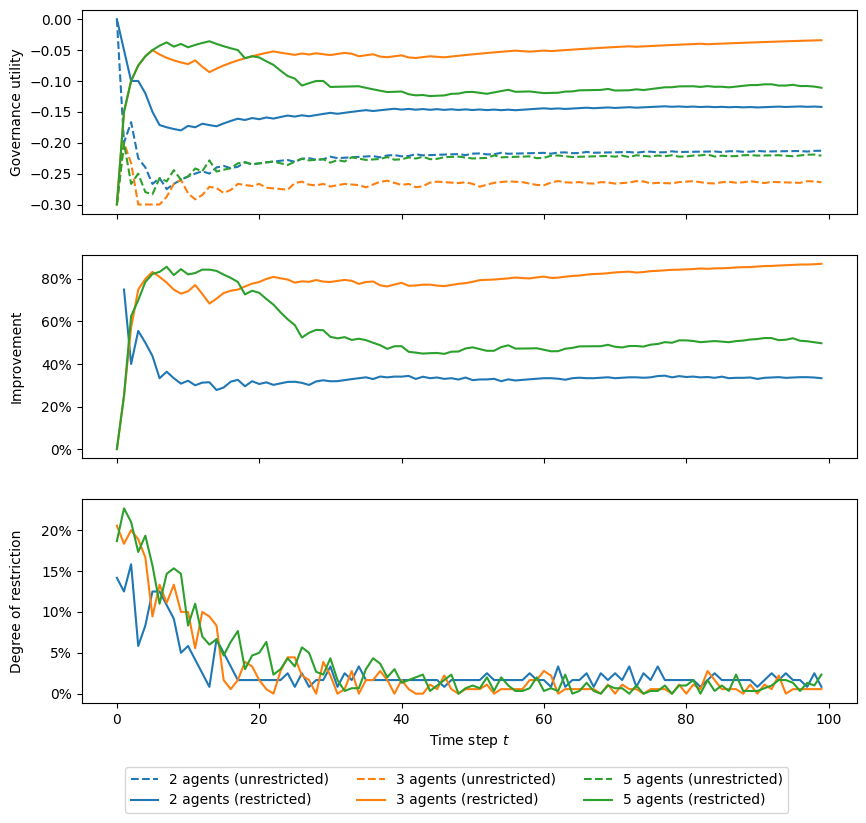

In [98]:
numbers_of_agents = [2, 3, 5]
colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
line_styles = {'unrestricted': 'dashed', 'restricted': 'solid'}

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

for number_of_agents in numbers_of_agents:
    ax1.plot(governance_utility[f'{number_of_agents} agents (unrestricted)'], color=colors[number_of_agents], label='Unrestricted', linestyle=line_styles['unrestricted'])
    ax1.plot(governance_utility[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label='Restricted', linestyle=line_styles['restricted'])

    ax2.plot(improvement[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label=f'{number_of_agents} agents')

    ax3.plot(degree_of_restriction[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label=f'{number_of_agents} agents')

lgd = fig.legend(labels=[f'{number_of_agents} agents ({type})' for number_of_agents in numbers_of_agents for type in ['unrestricted', 'restricted']], 
    loc='outside lower center', 
    ncol=3,
    bbox_to_anchor=(0.5, -0.02))

ax1.set_ylabel('Governance utility')

ax2.set_ylabel(r'Improvement')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.set_xlabel(r'Time step $t$')
ax3.set_ylabel('Degree of restriction')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))

# plt.tight_layout()
fig.align_labels()
# fig.savefig(f'{name}.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')